#### Step 1
Train a NN to fit a Gaussian/Normal distribution using GAN architecture (discriminator & generator).

<div>
<img src="dist.gif" width="400"/>
</div>

**Imports**

In [177]:
import numpy as np

import torch
from torch import nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.animation

from time import time
from IPython.display import display, clear_output


**Disabling autoscrolling for long output:**

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Generator

In [3]:
class Generator_distribution(nn.Module):
    def __init__(self,input_dim=1):
        # initialize nn Module
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        # architecture
        self.layers.append(nn.Linear(input_dim,64))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(64,32))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(32,1))
        
    def forward(self,input_tensor):
        x = input_tensor
        for l in self.layers:
            x = l(x)
        return x
    
yoyo = Generator_distribution()
yoyo.forward(torch.rand(10,1))

tensor([[-0.0461],
        [-0.0506],
        [-0.0397],
        [-0.0634],
        [-0.0394],
        [-0.0610],
        [-0.0130],
        [-0.0163],
        [-0.0374],
        [-0.0143]], grad_fn=<AddmmBackward>)

# Discriminator

In [4]:
class Discriminator_distribution(nn.Module):
    def __init__(self,input_dim=1):
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        self.layers.append(nn.Linear(input_dim,64))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(64,32))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(32,1))
        self.layers.append(nn.Sigmoid())
    
    def forward(self,input_tensor):
        x = input_tensor
        for l in self.layers:
            x = l(x)
        return x

yoyo = Discriminator_distribution(input_dim=1)
yoyo.forward(torch.rand(10,1))

tensor([[0.4648],
        [0.4655],
        [0.4682],
        [0.4668],
        [0.4586],
        [0.4695],
        [0.4585],
        [0.4663],
        [0.4662],
        [0.4644]], grad_fn=<SigmoidBackward>)

In [5]:
initial = torch.rand
# self.real    = torch.randn
noise_fn = lambda x: torch.rand((x, 1), device='cpu')
# data_fn = lambda x: torch.randn((x, 1), device='cpu')
initial(10), noise_fn(10)


(tensor([0.6405, 0.8977, 0.7454, 0.3505, 0.0726, 0.3153, 0.8777, 0.3368, 0.2951,
         0.4250]),
 tensor([[0.8844],
         [0.5602],
         [0.0267],
         [0.9533],
         [0.6880],
         [0.4182],
         [0.0308],
         [0.6438],
         [0.8977],
         [0.5181]]))

# Gan

In [213]:
class GAN_distribution():
    def __init__(self,batch_size=10,n_epochs=600,lr_generator=0.0001,lr_discriminator=0.0004,from_dist=torch.rand,to_dist=torch.randn):
        
        # models
        self.generator     = Generator_distribution()
        self.discriminator = Discriminator_distribution()
        
        # criterion
        self.criterion = nn.BCELoss()
        
        # optimizers
        self.optim_generator     = optim.Adam(self.generator.parameters(),    lr=lr_generator)
        self.optim_discriminator = optim.Adam(self.discriminator.parameters(),lr=lr_discriminator)
        
        # distrebutions from & to
        self.initial = from_dist
        self.real    = to_dist
        
        # batch
        self.batch_size = batch_size
            
        # epochs    
        self.n_epochs=n_epochs

        # helper for loss
        self.ones = torch.ones((batch_size, 1))
        self.zeros = torch.zeros((batch_size, 1))
        
        
    def sample_gen(self,num=1000):
        with torch.no_grad():
                return self.generator(self.initial((num,1)))
     
    
    def train_step(self):
        loss_discriminator = self.train_step_discriminator()
        loss_generator = self.train_step_generator()
        return loss_generator,loss_discriminator
   
    
    def train_step_generator(self):
        
        self.generator.zero_grad()
        
        # gen
        sample = self.initial((self.batch_size,1))
        gen = self.generator(sample)
        cls = self.discriminator(gen)
        
        # adjusting the gen's Ws in order to fool the discriminator
        loss = self.criterion(cls,self.ones)
        loss.backward()
        self.optim_generator.step()
        return loss.item()
    
    
    def train_step_discriminator(self):
        
        self.discriminator.zero_grad()
        
        # real
        sample = self.real((self.batch_size,1))
        pred_real = self.discriminator(sample)
        loss_real = self.criterion(pred_real,self.ones)
        
        # gen
        sample = self.initial((self.batch_size,1))
        with torch.no_grad():
            gen = self.generator(sample)
        pred_fake = self.discriminator(gen)
        loss_fake = self.criterion(pred_fake,self.zeros)
        
        # combine losses
        loss = (loss_real + loss_fake)/2
        loss.backward()
        self.optim_discriminator.step()
        return loss_real.item(),loss_fake.item()

    
    def train(self,verbose_instead_of_animation=False):
        self.loss_g, self.loss_d_real, self.loss_d_fake = [], [], []

        self.samples = []
        start = time()
        for epoch in range(self.n_epochs):
            
            loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
            
            for batch in range(self.batch_size):
                lg_, (ldr_, ldf_) = self.train_step()
                loss_g_running += lg_
                loss_d_real_running += ldr_
                loss_d_fake_running += ldf_
            
            self.loss_g.append(loss_g_running / self.batch_size)
            self.loss_d_real.append(loss_d_real_running / self.batch_size)
            self.loss_d_fake.append(loss_d_fake_running / self.batch_size)
            self.samples.append(self.sample_gen())
            
            if verbose_instead_of_animation and ((epoch+1)%100==0):
                print(f"Epoch {epoch+1}/{self.n_epochs} ({int(time() - start)}s):"
                      f" G={self.loss_g[-1]:.3f},"
                      f" Dr={self.loss_d_real[-1]:.3f},"
                      f" Df={self.loss_d_fake[-1]:.3f}")
        
        if not verbose_instead_of_animation:
            self.plot_animation()
        
    
    def plot(self,num=100):
        fig, ax = plt.subplots(1,2,figsize=(18,6))

        # plot Loss
        ax[0].plot(self.loss_g,label='Generator Loss')
        ax[0].plot(self.loss_d_real,label='Discriminator Loss on Real data')
        ax[0].plot(self.loss_d_fake,label='Discriminator Loss on Fake data')
        ax[0].set_title('Loss')
        ax[0].legend()

        # plot distribution
        arr = self.sample_gen(num=num).detach().numpy()
        sns.distplot(self.real(num),label='Real',hist_kws=dict(alpha=1),ax=ax[1])
        sns.distplot(arr,label='GAN',hist_kws=dict(alpha=0.5),ax=ax[1])
        ax[1].set_title('Distributions')
        ax[1].legend()
        
    def plot_animation(self):
        fig, ax = plt.subplots(1,2,figsize=(18,6))
        
        # Plot Loss
        l, = ax[0].plot([0,10],[0,2])
        l2, = ax[0].plot([0,10],[0,2])
        l3, = ax[0].plot([0,10],[0,2])
        ax[0].legend(['Generator Loss','Discriminator Loss on Real data','Discriminator Loss on Fake data'])
        ax[0].set_title('Loss')

        # Plot loss - animations functions
        t = np.a
        animate_g = lambda i: l.set_data(t[:i], self.loss_g[:i])
        animate_d_real = lambda i: l2.set_data(t[:i], self.loss_d_real[:i])
        animate_d_fake = lambda i: l3.set_data(t[:i], self.loss_d_fake[:i])
        
        # Plot distribution
        num = len(self.samples[0])
        real_ = self.real(num)
        fake_ = [np.array(s) for s in self.samples]
        
        # Plot distribution - animation function
        def animate_samples(i):
            ax[1].clear();
            sns.distplot(real_,label='Real',hist_kws=dict(alpha=1),ax=ax[1])
            sns.distplot(fake_[i],label='GAN',hist_kws=dict(alpha=0.5),ax=ax[1])
            ax[1].legend()
            ax[1].set_title('Distributions')

            
        # Plot each epoch - Loss & distribution
        for i in range(self.n_epochs):
            # call animation functions
            animate_g(i)
            animate_d_real(i)
            animate_d_fake(i)
            animate_samples(i)
            
            # clear output anf dislay figure
            clear_output(wait=True)
            display(fig)
            
            # Plot Loss - scale the plot by new values
            ax[0].relim()
            ax[0].autoscale_view(True,True)
            
            # Plot distribution - scale the plot by new values
            ax[1].relim()
            ax[1].autoscale_view(True,True)
            
            # show entire plot
            plt.show()
            
        
        
        

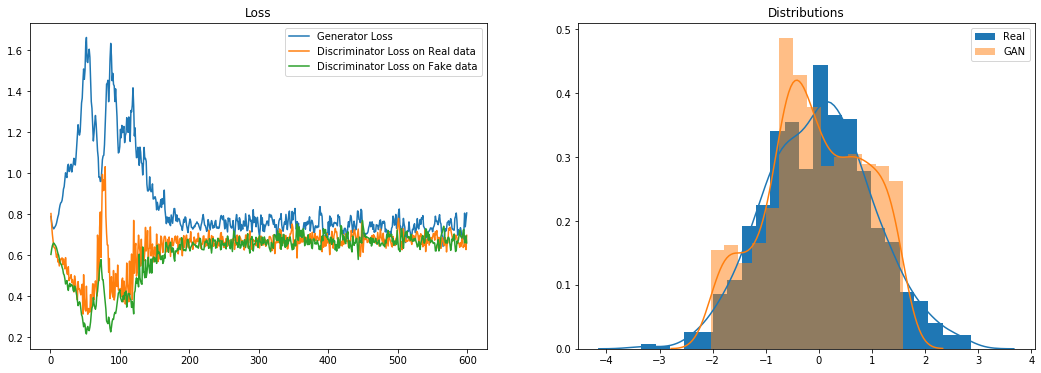

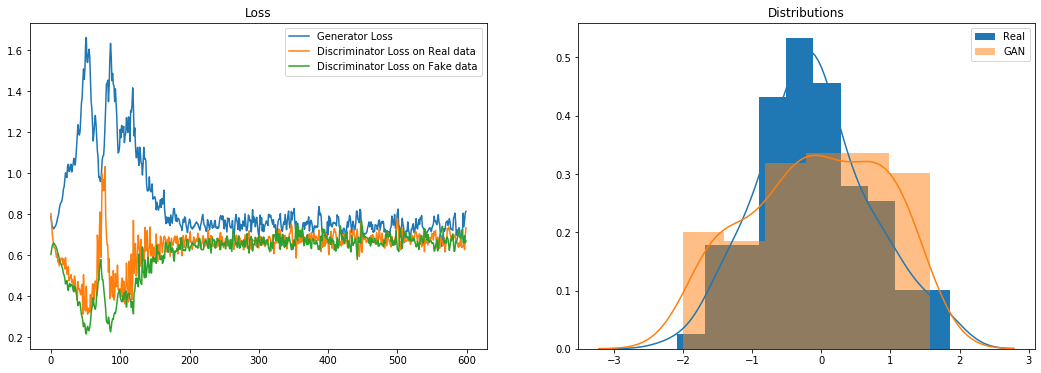

In [214]:
gan = GAN_distribution()
gan.train()

gan.plot()